In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [2]:
# Read the dataset
# Transform the excel file in csv file
df = pd.read_excel('energy_demand.xlsx')

csv_file_path = 'energy_demand.csv'

df.to_csv(csv_file_path, index = False)

print(df)

            Date  Hour    load          T
0     2012-01-01     0  2872.0  30.666667
1     2012-01-01     1  2698.0  32.000000
2     2012-01-01     2  2558.0  32.666667
3     2012-01-01     3  2444.0  30.000000
4     2012-01-01     4  2402.0  31.000000
...          ...   ...     ...        ...
26300 2014-12-31    20  4012.0  18.000000
26301 2014-12-31    21  3856.0  16.666667
26302 2014-12-31    22  3671.0  17.000000
26303 2014-12-31    23  3499.0  15.333333
26304 2014-12-31    24  3345.0  15.333333

[26305 rows x 4 columns]


In [3]:
# Data Preparation

# Display columns names
print(df.columns)

# Change the column names
new_column_names = {
    'load' : 'Load Value',
    'T' : 'Temperature'
}

df.rename(columns = new_column_names, inplace = True)

print("Update columns : ")
print(df.columns)

Index(['Date', 'Hour', 'load', 'T'], dtype='object')
Update columns : 
Index(['Date', 'Hour', 'Load Value', 'Temperature'], dtype='object')


In [4]:
# Display basic information for dataset
print(df.info())

# Check data types
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26305 entries, 0 to 26304
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         26305 non-null  datetime64[ns]
 1   Hour         26305 non-null  int64         
 2   Load Value   26305 non-null  float64       
 3   Temperature  26305 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 822.2 KB
None
Date           datetime64[ns]
Hour                    int64
Load Value            float64
Temperature           float64
dtype: object


In [5]:
# Display first few rows
print(df.head())

# Display last few rows
print(df.tail())

        Date  Hour  Load Value  Temperature
0 2012-01-01     0      2872.0    30.666667
1 2012-01-01     1      2698.0    32.000000
2 2012-01-01     2      2558.0    32.666667
3 2012-01-01     3      2444.0    30.000000
4 2012-01-01     4      2402.0    31.000000
            Date  Hour  Load Value  Temperature
26300 2014-12-31    20      4012.0    18.000000
26301 2014-12-31    21      3856.0    16.666667
26302 2014-12-31    22      3671.0    17.000000
26303 2014-12-31    23      3499.0    15.333333
26304 2014-12-31    24      3345.0    15.333333


In [6]:
# Display descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())
# Doesn't have missing values in the dataset

                                Date          Hour    Load Value   Temperature
count                          26305  26305.000000  26305.000000  26305.000000
mean   2013-07-01 11:30:01.710701312     12.499525   3303.752785     47.764988
min              2012-01-01 00:00:00      0.000000   1979.000000    -13.666667
25%              2012-09-30 00:00:00      6.000000   2867.000000     32.666667
50%              2013-07-01 00:00:00     12.000000   3364.000000     48.333333
75%              2014-04-01 00:00:00     18.000000   3690.000000     63.666667
max              2014-12-31 00:00:00     24.000000   5224.000000     95.000000
std                              NaN      6.922616    564.574798     19.338062
Date           0
Hour           0
Load Value     0
Temperature    0
dtype: int64


In [7]:
# Display unique values
for column in df.columns:
    # Print the column name and its unique values
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in Date: <DatetimeArray>
['2012-01-01 00:00:00', '2012-01-02 00:00:00', '2012-01-03 00:00:00',
 '2012-01-04 00:00:00', '2012-01-05 00:00:00', '2012-01-06 00:00:00',
 '2012-01-07 00:00:00', '2012-01-08 00:00:00', '2012-01-09 00:00:00',
 '2012-01-10 00:00:00',
 ...
 '2014-12-22 00:00:00', '2014-12-23 00:00:00', '2014-12-24 00:00:00',
 '2014-12-25 00:00:00', '2014-12-26 00:00:00', '2014-12-27 00:00:00',
 '2014-12-28 00:00:00', '2014-12-29 00:00:00', '2014-12-30 00:00:00',
 '2014-12-31 00:00:00']
Length: 1096, dtype: datetime64[ns]
Unique values in Hour: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Unique values in Load Value: [2872. 2698. 2558. ... 4449. 4360. 4319.]
Unique values in Temperature: [ 30.666667    32.          32.66666667  30.          31.
  31.33333333  29.          33.33333333  36.66666667  40.33333333
  43.66666667  43.33333333  45.          44.66666667  41.66666667
  41.33333333  42.66666667  44.33333333  44.          43.
  

In [8]:
# Check for duplicated values
print(df.duplicated().sum())
# Don't have duplicated values

0


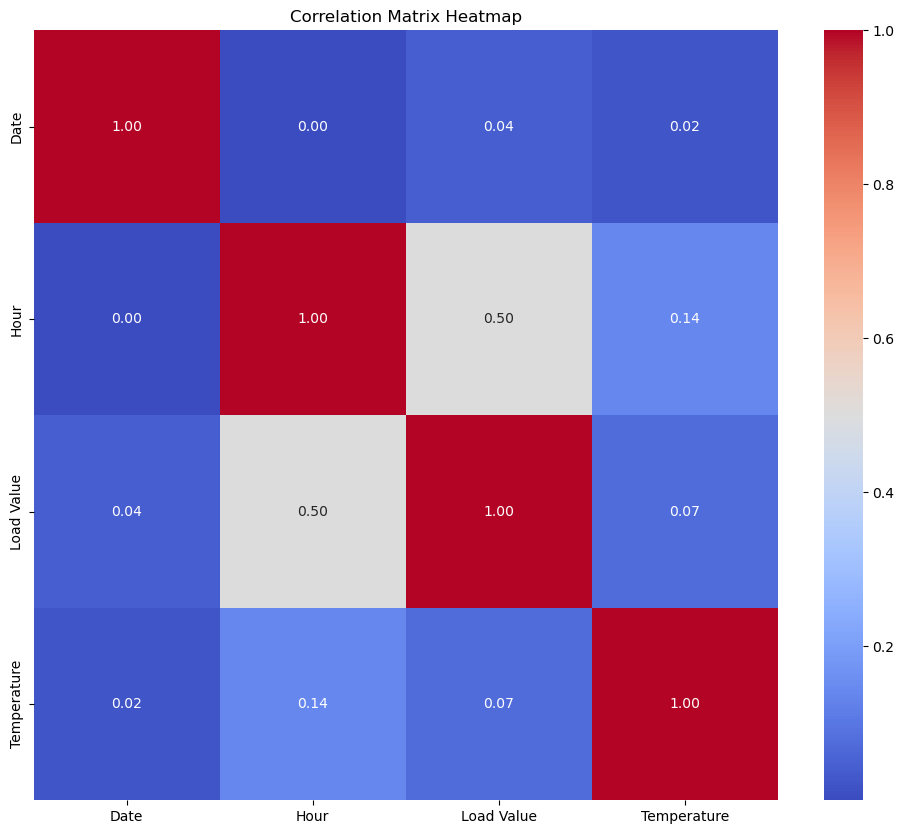

In [9]:
# Display correlation matrix
correlation_matrix = df.corr()

plt.figure(figsize = (12,10))

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")

plt.title('Correlation Matrix Heatmap')
plt.show()
# We can see we have an medium correlation beetween hour and Loan Value

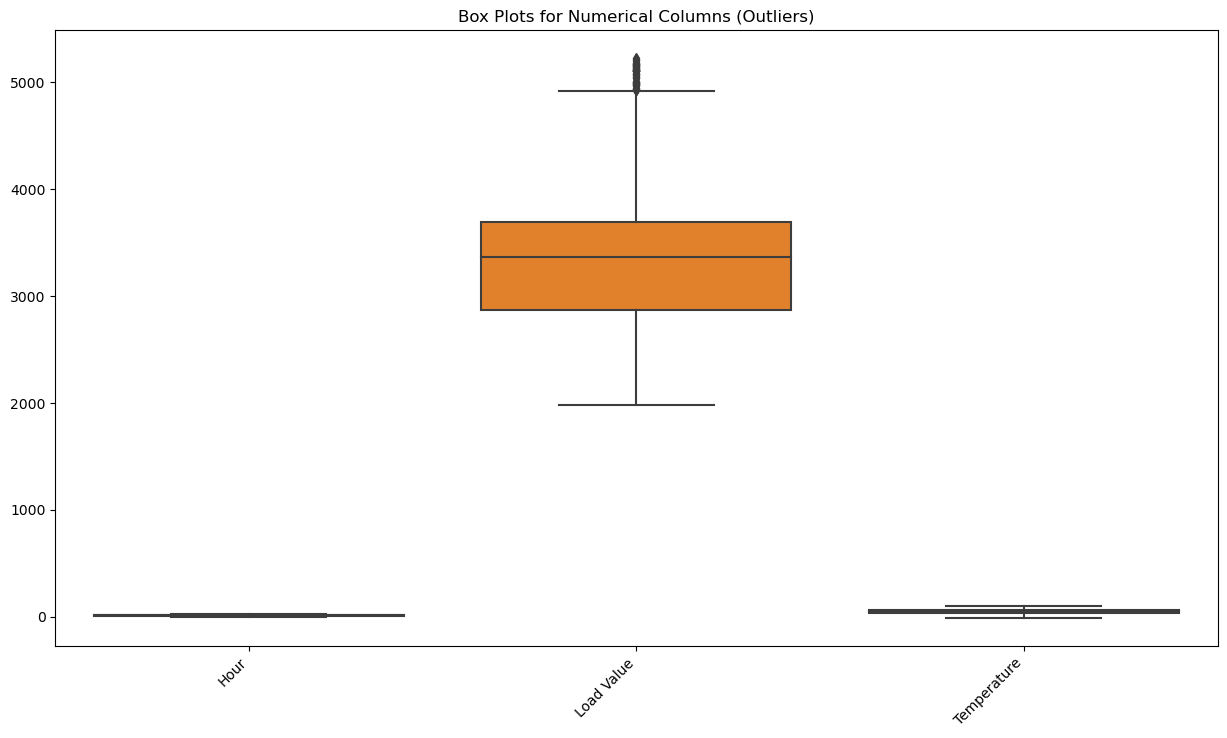

In [10]:
# Check for outliers in the dataset
numerical_columns = df.select_dtypes(include='number').columns

# Plot box plots for all numerical columns
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numerical_columns])
plt.title('Box Plots for Numerical Columns (Outliers)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()
# Only have outliers in the Load Value column

In [11]:
# Check for anomalies
z_scores = zscore(df['Load Value'])
anomalies = (z_scores > 3) | (z_scores < -3)

# Display rows with anomalies
anomalies_df = df[anomalies]
print("Anomalies:")
print(anomalies_df)
print(anomalies_df.nunique())

Anomalies:
            Date  Hour  Load Value  Temperature
13476 2013-07-15    12      5007.0    86.000000
13477 2013-07-15    13      5040.0    88.000000
13478 2013-07-15    14      5088.0    89.333333
13479 2013-07-15    15      5112.0    90.333333
13480 2013-07-15    16      5132.0    91.000000
13481 2013-07-15    17      5151.0    91.666667
13482 2013-07-15    18      5152.0    91.333333
13483 2013-07-15    19      5113.0    89.666667
13500 2013-07-16    12      5053.0    86.666667
13501 2013-07-16    13      5103.0    88.333333
13502 2013-07-16    14      5147.0    88.666667
13503 2013-07-16    15      5124.0    87.666667
13504 2013-07-16    16      5104.0    88.000000
13505 2013-07-16    17      5110.0    90.000000
13506 2013-07-16    18      5098.0    89.666667
13507 2013-07-16    19      5042.0    87.000000
13525 2013-07-17    13      5076.0    86.333333
13526 2013-07-17    14      5133.0    88.666667
13527 2013-07-17    15      5166.0    89.000000
13528 2013-07-17    16      5

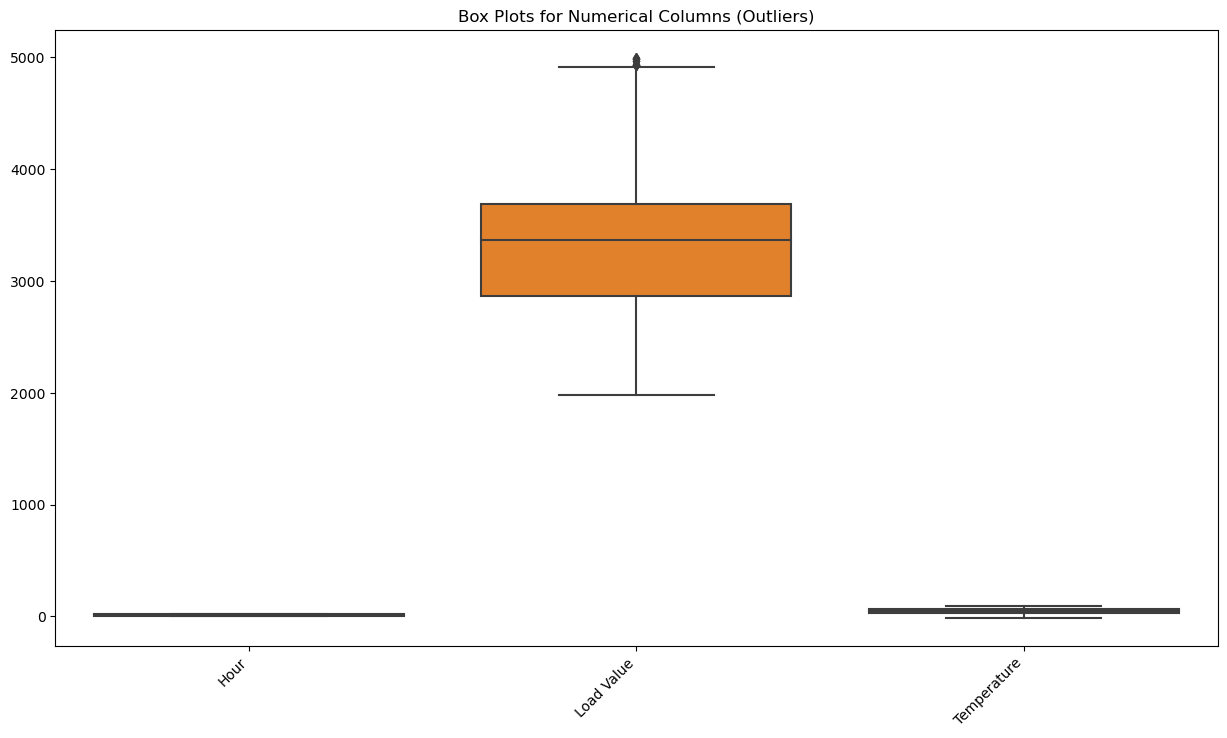

In [12]:
# Remove rows with anomalies
df_no_anomalies = df[~anomalies]
df = df_no_anomalies

# Check for outliers in the dataset
numerical_columns = df.select_dtypes(include='number').columns

# Plot box plots for all numerical columns
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numerical_columns])
plt.title('Box Plots for Numerical Columns (Outliers)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [13]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')

# Create a new column 'DateTime' by combining 'Date' and 'Hour'
df['DateTime'] = df['Date'] + df['Hour']

# Drop the original 'Date' and 'Hour' columns if needed
df.drop(['Date', 'Hour'], axis=1, inplace=True)

print(df)

# Set DateTime as index of DataFrame
df.set_index('DateTime', inplace=True)

print(df)



       Load Value  Temperature            DateTime
0          2872.0    30.666667 2012-01-01 00:00:00
1          2698.0    32.000000 2012-01-01 01:00:00
2          2558.0    32.666667 2012-01-01 02:00:00
3          2444.0    30.000000 2012-01-01 03:00:00
4          2402.0    31.000000 2012-01-01 04:00:00
...           ...          ...                 ...
26300      4012.0    18.000000 2014-12-31 20:00:00
26301      3856.0    16.666667 2014-12-31 21:00:00
26302      3671.0    17.000000 2014-12-31 22:00:00
26303      3499.0    15.333333 2014-12-31 23:00:00
26304      3345.0    15.333333 2015-01-01 00:00:00

[26266 rows x 3 columns]
                     Load Value  Temperature
DateTime                                    
2012-01-01 00:00:00      2872.0    30.666667
2012-01-01 01:00:00      2698.0    32.000000
2012-01-01 02:00:00      2558.0    32.666667
2012-01-01 03:00:00      2444.0    30.000000
2012-01-01 04:00:00      2402.0    31.000000
...                         ...          ...
20

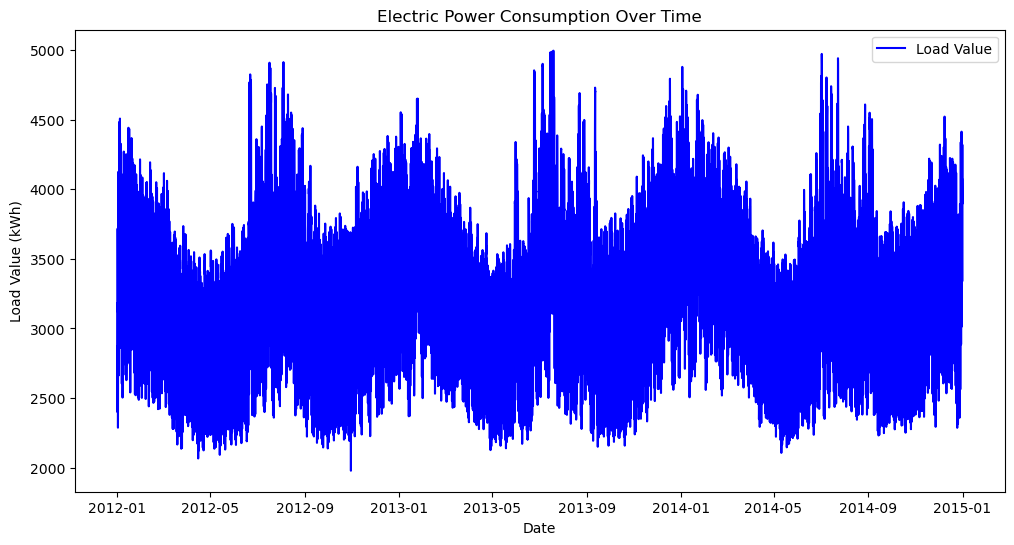

In [14]:
# Plot the time series of Load values
plt.figure(figsize=(12, 6))
plt.plot(df['Load Value'], label='Load Value', color='blue')
plt.title('Electric Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Load Value (kWh)')
plt.legend()
plt.show()

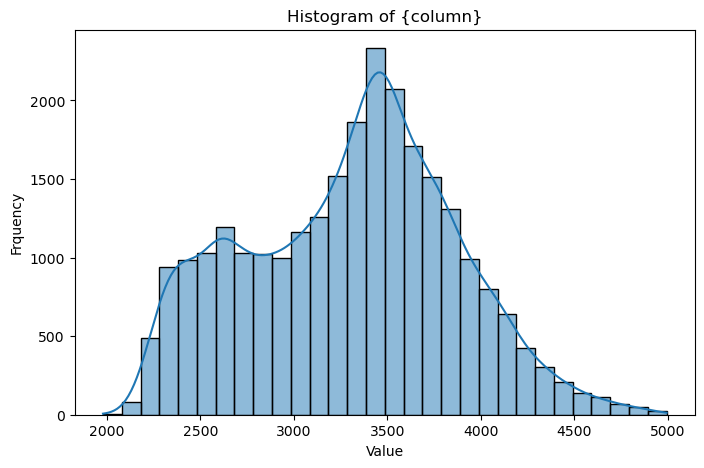

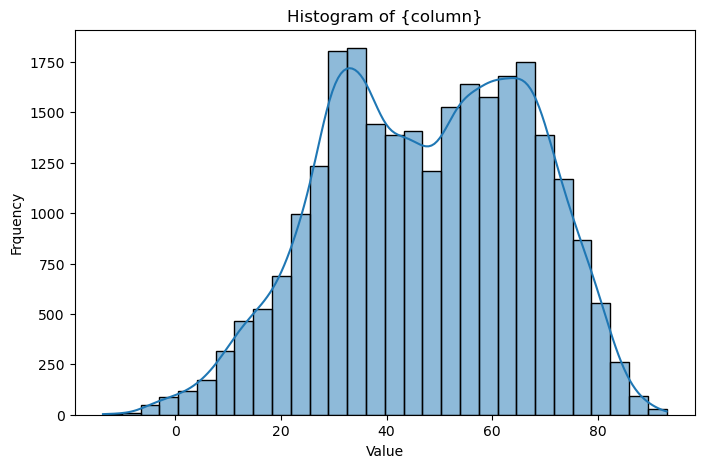

In [15]:
# Univariate Visualization
for column in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df[column], bins=30, kde=True)
    plt.title('Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frquency')
    plt.show()

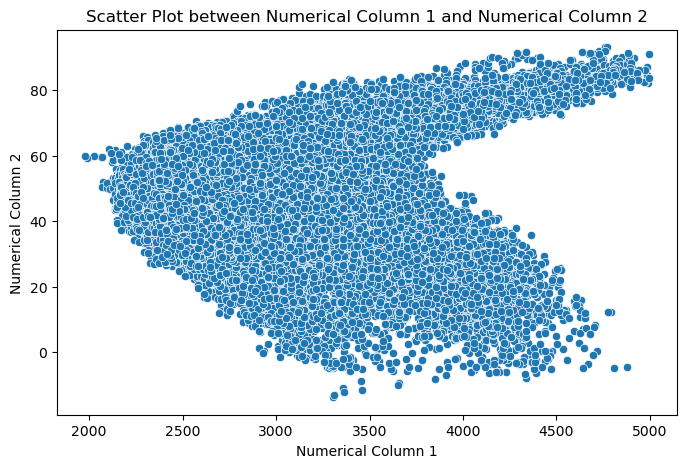

In [16]:
# Scatter plot for two numerical columns
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Load Value'], y=df['Temperature'])
plt.title('Scatter Plot between Numerical Column 1 and Numerical Column 2')
plt.xlabel('Numerical Column 1')
plt.ylabel('Numerical Column 2')
plt.show()

In [17]:
# Split data into train-val-test
# Calculate the split points
total_samples = len(df)
train_split = int(0.8 * total_samples)
val_split = int(0.9 * total_samples)

# Split the data
train_set = df.iloc[:train_split]
val_set = df.iloc[train_split:val_split]
test_set = df.iloc[val_split:]

print(f"Train dates      : {train_set.index.min()} --- {train_set.index.max()}  (n={len(train_set)})")
print(f"Validation dates : {val_set.index.min()} --- {val_set.index.max()}  (n={len(val_set)})")
print(f"Test dates       : {test_set.index.min()} --- {test_set.index.max()}  (n={len(test_set)})")

Train dates      : 2012-01-01 00:00:00 --- 2014-05-27 00:00:00  (n=21012)
Validation dates : 2014-05-27 01:00:00 --- 2014-09-13 13:00:00  (n=2627)
Test dates       : 2014-09-13 14:00:00 --- 2015-01-01 00:00:00  (n=2627)


In [18]:
# Interactive plot of time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_set.index, y=train_set['Load Value'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=val_set.index, y=val_set['Load Value'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=test_set.index, y=test_set['Load Value'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="Load Value",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

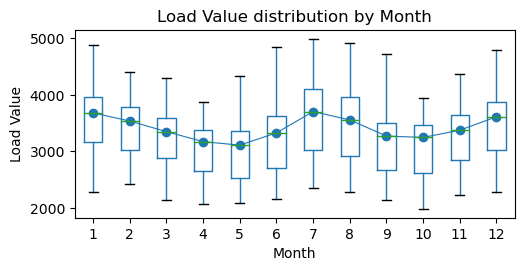

In [20]:
# Demand distribution by Month
fig, ax = plt.subplots(figsize=(5.5, 2.5))
df['Month'] = df.index.month
df.boxplot(column='Load Value', by='Month', ax=ax,)
df.groupby('Month')['Load Value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load Value')
ax.set_title('Load Value distribution by Month')
fig.suptitle('')
plt.show()

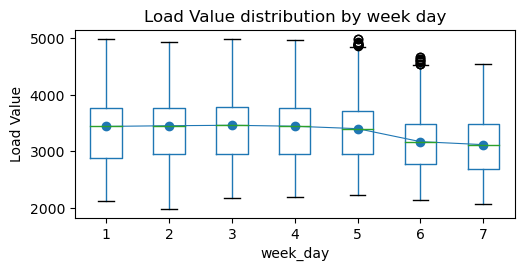

In [21]:
# Demand distribution by week day

fig, ax = plt.subplots(figsize=(5.5, 2.5))
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='Load Value', by='week_day', ax=ax)
df.groupby('week_day')['Load Value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load Value')
ax.set_title('Load Value distribution by week day')
fig.suptitle('')
plt.show()

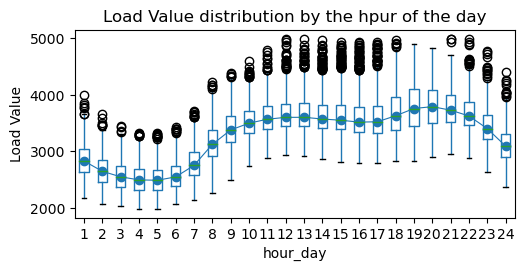

In [22]:
# Demand distribution by the hour of the day

fig, ax = plt.subplots(figsize=(5.5, 2.5))
df['hour_day'] = df.index.hour + 1
df.boxplot(column='Load Value', by='hour_day', ax=ax)
df.groupby('hour_day')['Load Value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Load Value')
ax.set_title('Load Value distribution by the hpur of the day')
fig.suptitle('')
plt.show()

In [23]:
# Split data into training and testing sets
# Start by choose a percentage of data to train
train_percentage = 0.8
split_index = int(len(df) * train_percentage)

# Split the dataset
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(df):
      train_data, test_data = df.iloc[train_index], df.iloc[test_index]

# Separate features (X) and target variable (y) for training and testing sets
X_train, y_train = train_data.drop('Load Value', axis=1), train_data['Load Value']
X_test, y_test = test_data.drop('Load Value', axis=1), test_data['Load Value']

In [24]:
# Define a function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Linear Regression MAE: 332.7684845679203, RMSE: 417.88345952665094, MAPE: 10.08176106209184%


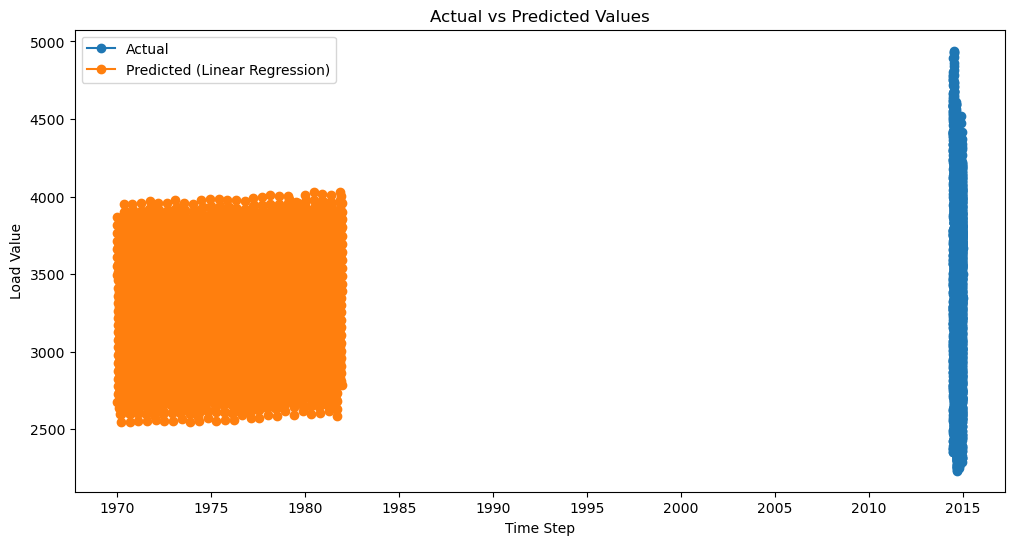

In [29]:
# Machine Learning Models
# Start by initialize the regression models:
# 1) Linear Regression
linear_model = LinearRegression()

# Start by do the train model
linear_model.fit(X_train, y_train)

# Make the prediction
linear_pred = linear_model.predict(X_test)

# Evaluate model
linear_mae = mean_absolute_error(y_test, linear_pred)

linear_rmse = mean_squared_error(y_test, linear_pred, squared=False)

linear_mape = calculate_mape(y_test, linear_pred)

print(f"Linear Regression MAE: {linear_mae}, RMSE: {linear_rmse}, MAPE: {linear_mape}%")

# Example with Linear Regression
y_pred_best_lr = linear_pred

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o')

# Plot predicted values for Linear Regression
plt.plot(y_pred_best_lr, label='Predicted (Linear Regression)', marker='o')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Load Value')
plt.legend()
plt.show()

Decision Tree MAE: 129.8635671312162, RMSE: 184.4540998064142, MAPE: 3.8751307102023618%


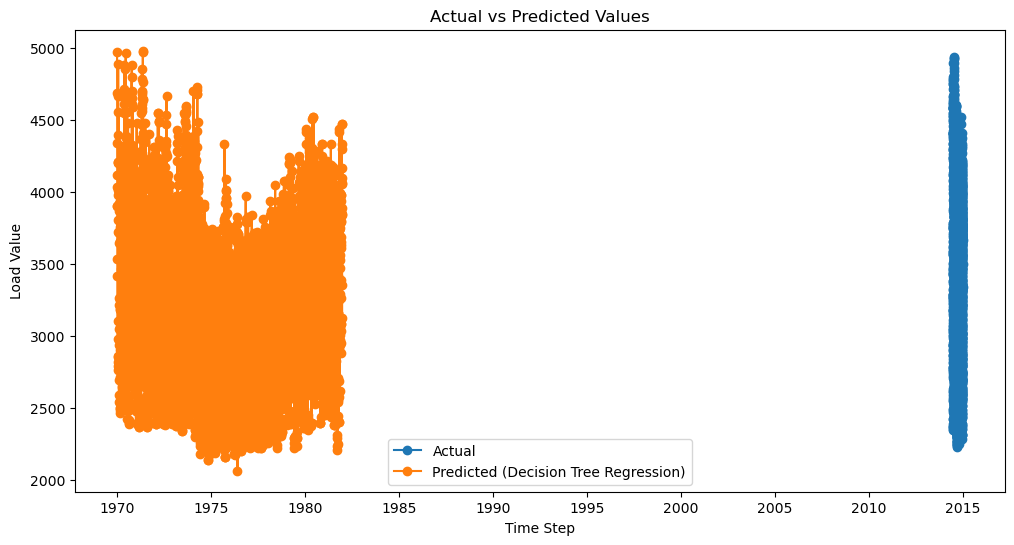

In [30]:
# 2) Decision Tree Regression
tree_model = DecisionTreeRegressor()

# Start by do the train model
tree_model.fit(X_train, y_train)

# Make the prediction
tree_pred = tree_model.predict(X_test)

# Evaluate model
tree_mae = mean_absolute_error(y_test, tree_pred)

tree_rmse = mean_squared_error(y_test, tree_pred, squared=False)

tree_mape = calculate_mape(y_test, tree_pred)

print(f"Decision Tree MAE: {tree_mae}, RMSE: {tree_rmse}, MAPE: {tree_mape}%")

# Example with Linear Regression
y_pred_best_lr = tree_pred

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o')

# Plot predicted values for Decision Tree Regression
plt.plot(y_pred_best_lr, label='Predicted (Decision Tree Regression)', marker='o')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Load Value')
plt.legend()
plt.show()

Random Forest MAE: 105.94306947300282, RMSE: 149.39396984787106 , MAPE: 3.1792147288236148%


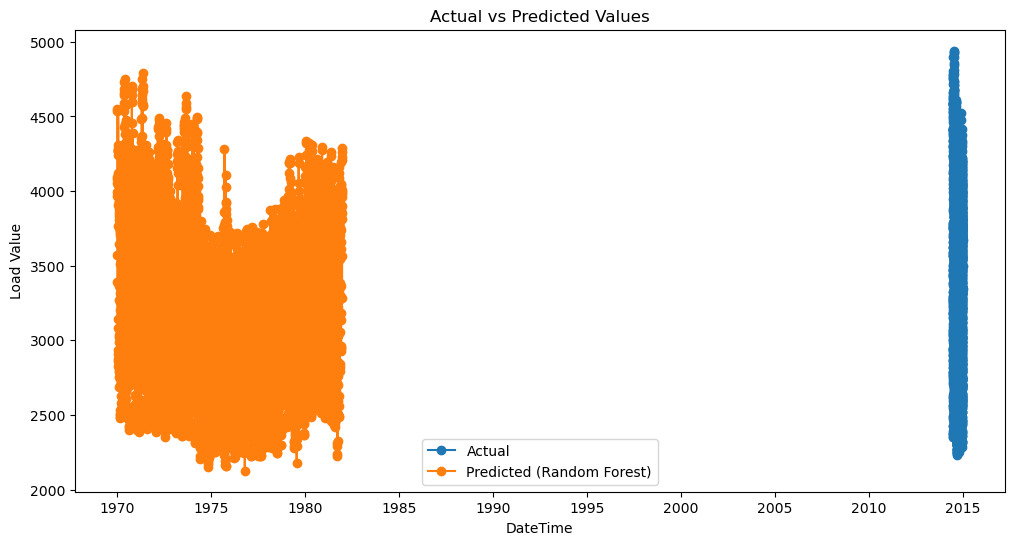

In [28]:
# 3) Random Forest Regression
rf_model = RandomForestRegressor()

# Start by do the train model
rf_model.fit(X_train, y_train)

# Make the prediction
rf_pred = rf_model.predict(X_test)

# Evaluate model
rf_mae = mean_absolute_error(y_test, rf_pred)

rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)

rf_mape = calculate_mape(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae}, RMSE: {rf_rmse} , MAPE: {rf_mape}%")

# Example with Random Forest Regressor
y_pred_best_rf = rf_pred

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o')

# Plot predicted values for Random Forest Regressor
plt.plot(y_pred_best_rf, label='Predicted (Random Forest)', marker='o')

plt.title('Actual vs Predicted Values')
plt.xlabel('Date Time')
plt.ylabel('Load Value')
plt.legend()
plt.show()

Gradient Boosting MAE: 107.40293199027428, RMSE: 149.32262000905232, MAPE: 3.1885492232615302%


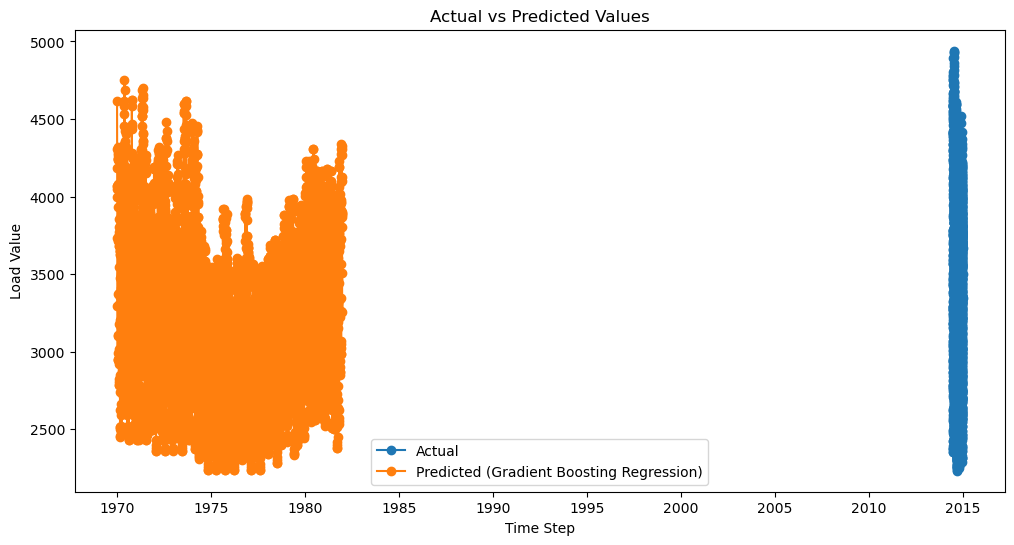

In [31]:
# 4) Gradient Boosting Regression
gb_model = GradientBoostingRegressor()

# Start by do the train model
gb_model.fit(X_train, y_train)

# Make the prediction
gb_pred = gb_model.predict(X_test)

# Evaluate model
gb_mae = mean_absolute_error(y_test, gb_pred)

gb_rmse = mean_squared_error(y_test, gb_pred, squared=False)

gb_mape = calculate_mape(y_test, gb_pred)

print(f"Gradient Boosting MAE: {gb_mae}, RMSE: {gb_rmse}, MAPE: {gb_mape}%")

# Example with Linear Regression
y_pred_best_lr = gb_pred

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test, label='Actual', marker='o')

# Plot predicted values for Gradient Boosting Regression
plt.plot(y_pred_best_lr, label='Predicted (Gradient Boosting Regression)', marker='o')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Load Value')
plt.legend()
plt.show()

c:\Users\andre\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


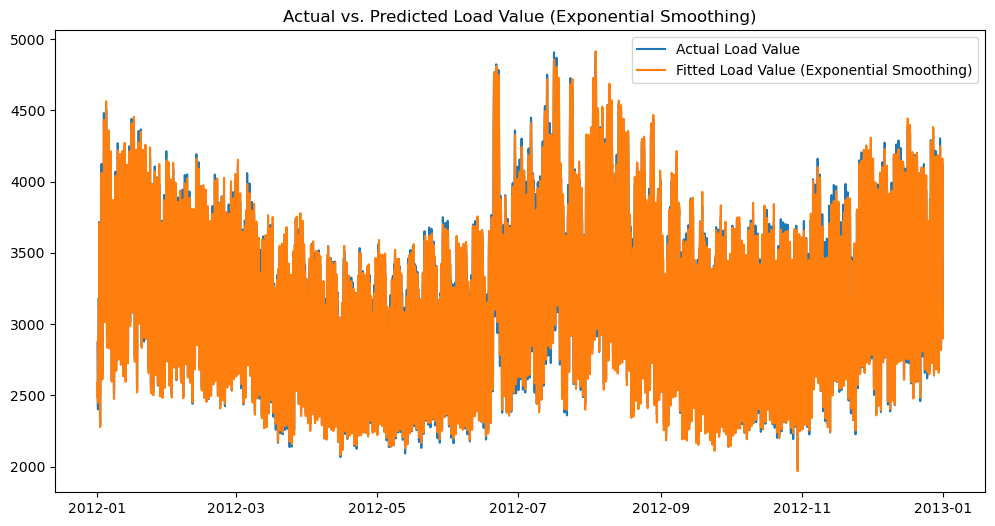

Exponential Smoothing Model Performance:
MAE: 45.23
RMSE: 62.72


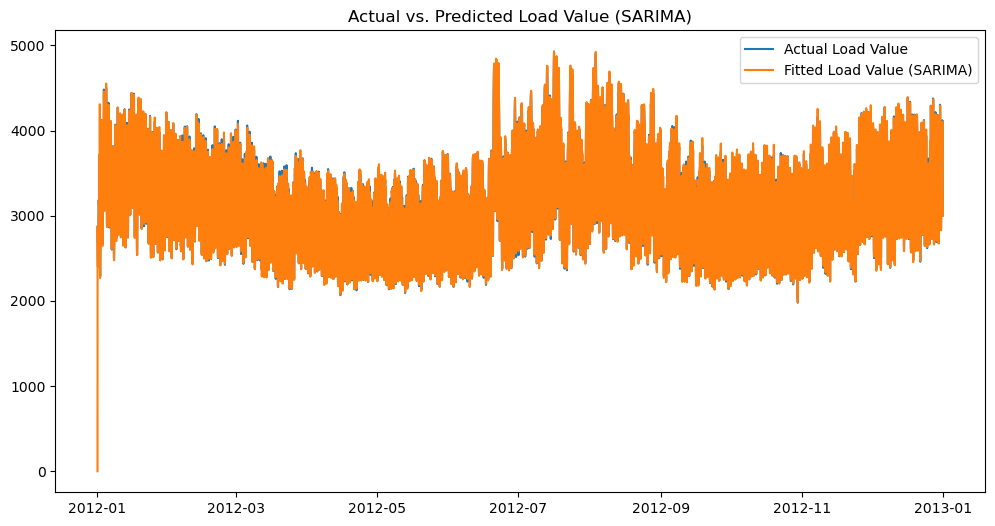


SARIMA Model Performance:
MAE: 25.94
RMSE: 51.12


In [ ]:
# Statistical Model

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the frequency explicitly to 'H' (hourly)
df = df.asfreq('H')

subset_start_date = '2012-01-01 00:00:00'
subset_end_date = '2013-01-01 00:00:00'
subset_data = df.loc[subset_start_date:subset_end_date]

# Exponential Smoothing
model_exp = ExponentialSmoothing(subset_data['Load Value'], trend='add', seasonal='add', seasonal_periods=24)
result_exp = model_exp.fit()
fitted_values_exp = result_exp.fittedvalues

# SARIMA
model_sarima = SARIMAX(subset_data['Load Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
result_sarima = model_sarima.fit()
fitted_values_sarima = result_sarima.fittedvalues

# Validate the model
mae_exp = mean_absolute_error(subset_data['Load Value'], fitted_values_exp)
rmse_exp = mean_squared_error(subset_data['Load Value'], fitted_values_exp, squared=False)

mae_sarima = mean_absolute_error(subset_data['Load Value'], fitted_values_sarima)
rmse_sarima = mean_squared_error(subset_data['Load Value'], fitted_values_sarima, squared=False)

# Visualize Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(subset_data['Load Value'], label='Actual Load Value')
plt.plot(fitted_values_exp, label='Fitted Load Value (Exponential Smoothing)')
plt.title('Actual vs. Predicted Load Value (Exponential Smoothing)')
plt.legend()
plt.show()

print("Exponential Smoothing Model Performance:")
print("MAE: {:.2f}".format(mae_exp))
print("RMSE: {:.2f}".format(rmse_exp))


plt.figure(figsize=(12, 6))
plt.plot(subset_data['Load Value'], label='Actual Load Value')
plt.plot(fitted_values_sarima, label='Fitted Load Value (SARIMA)')
plt.title('Actual vs. Predicted Load Value (SARIMA)')
plt.legend()
plt.show()

print("\nSARIMA Model Performance:")
print("MAE: {:.2f}".format(mae_sarima))
print("RMSE: {:.2f}".format(rmse_sarima))